# Predicting household power consumption using RNN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The household power consumption [dataset](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#) is taken from UCI Machine Learning Repository.

In [3]:
raw_data = pd.read_csv('data/household_power_consumption.txt',
                       delimiter=';',
                       usecols=['Date','Time', 'Global_active_power'],
                       low_memory=False)

In [4]:
raw_data.tail()

,Date,Time,Global_active_power
2075254,26/11/2010,20:58:00,0.946
2075255,26/11/2010,20:59:00,0.944
2075256,26/11/2010,21:00:00,0.938
2075257,26/11/2010,21:01:00,0.934
2075258,26/11/2010,21:02:00,0.932


In [11]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # Concatenate the "Date" and "Time" columns to create a "datetime" column
    # fix the data types of the "datetime" column and the "Global_active_power" column
    df = df.assign(
        datetime = lambda x: pd.to_datetime(x['Date'] + ' ' + x['Time']),
        Global_active_power = lambda x: pd.to_numeric(x['Global_active_power'], errors='coerce'),
    )
    df = df.dropna(subset=['Global_active_power'])
    df.sort_values(by='datetime', ascending=True, inplace=True)
    df = df.set_index("datetime")
    df.drop(['Date', 'Time'], axis=1, inplace=True)

    # Normalize the data
    max_power = df['Global_active_power'].max()
    min_power = df['Global_active_power'].min()
    # normalize using min-max formula to scale values between 0 and 1
    df['Global_active_power'] = (df['Global_active_power'] - min_power) / (max_power - min_power)
    return df, max_power, min_power

data, max_power, min_power = preprocess_data(raw_data)
data.tail()

C:\Users\Medhat\AppData\Local\Temp\ipykernel_26796\1914512914.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  datetime = lambda x: pd.to_datetime(x['Date'] + ' ' + x['Time']),


,Global_active_power
datetime,
2010-11-26 20:58:00,0.078762
2010-11-26 20:59:00,0.078580
2010-11-26 21:00:00,0.078037
2010-11-26 21:01:00,0.077675
2010-11-26 21:02:00,0.077494


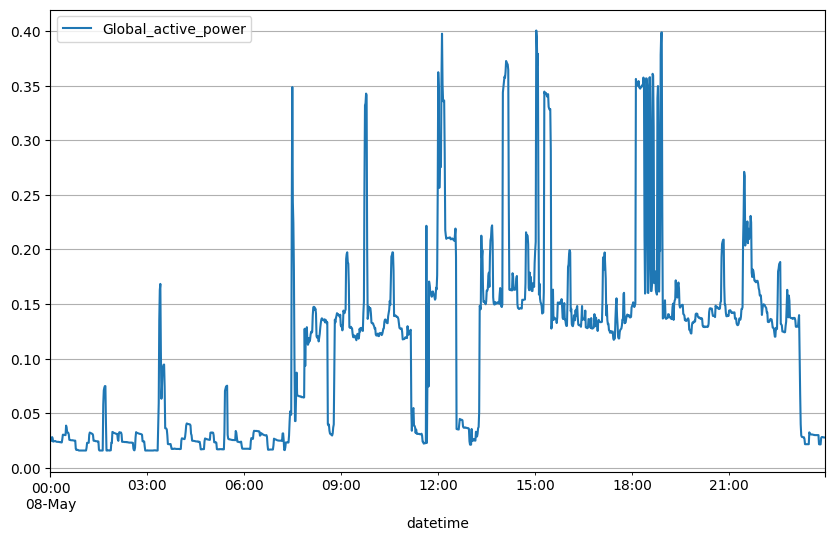

In [21]:
# Visualize power for a day
date1 = '2009-05-08'
_ = data.loc[date1].plot(kind='line', y='Global_active_power', figsize=(10, 6), grid=True)
plt.show()
plt.close()

In [55]:
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size].values
test_data = data.iloc[train_size:].values

def create_sequences(data, seq_len):
    """
    data: numpy array
        the input time series data
    seq_len:
        The length of the input sequence
    """

    # Initialize empty lists
    X = []
    y = []
    # Creating input sequences as follows
    # 0 : 6 excluding 6 - > output y = 6
    # 1 : 7 excluding 7 - > output y = 7
    # 2 : 8 excluding 8 - > output y = 8
    
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len: i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 6 # Hyperparameter for number of past steps to use for prediction

# Create Train and Test sequences
X_train, y_train = create_sequences(train_data, seq_len)
X_test, y_test = create_sequences(test_data, seq_len)

# convert numpy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [56]:
X_train[0]

tensor([[0.3748],
        [0.4784],
        [0.4796],
        [0.4809],
        [0.3250],
        [0.3118]])

In [57]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) # (batch, seq, feature)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :]) # Shape of out: (batch, last step, feature)
        return out, hidden

**Explanation**:

* First, the class is initialized with `input_size`, `hidden_size`, and `output_size`. These parameters define the size of the input, hidden state, and output of the RNN.
* The `super(RNN, self).__init__()` line initializes the class as a subclass of the `nn.Module` class in PyTorch, which provides some useful methods for defining and training neural networks.
* The `self.hidden_size = hidden_size` line sets the hidden size as an attribute of the class, so it can be accessed later in the forward method.
* The `nn.RNN` module is defined with the `input_size` and `hidden_size` parameters. The `batch_first=True` parameter indicates that the input to the RNN will have the batch dimension as the first dimension.
* The `nn.Linear` module is defined with the `hidden_size` and `output_size` parameters. This module will be used to map the final hidden state of the RNN to the output.
* The forward method takes two arguments: `x` and `hidden`. `x` is the input to the RNN, which is a tensor of shape `(batch_size, seq_len, input_size)`. `hidden` is the initial hidden state of the RNN, which is a tensor of shape `(1, batch_size, hidden_size)`.
* The `nn.RNN` module is called with `x` and `hidden` as inputs, and the output is stored in `out`. The `out` tensor has shape `(batch_size, seq_len, hidden_size)`, where `seq_len` is the length of the input sequence.
* The `out[:, -1, :]` indexing extracts the last hidden state of the RNN for each sequence in the batch. This tensor has shape `(batch_size, hidden_size)`.
* The `nn.Linear` module is called with the last hidden state as input, and the output is stored in `out`. The `out` tensor has shape `(batch_size, output_size)`.
* Finally, the `out` and `hidden` tensors are returned as the output of the forward method.

Overall, this code defines a simple RNN model that takes an input sequence, processes it with an RNN layer, and maps the final hidden state to an output.

### Set Hyperparameters

In [58]:
input_size = 1   # number of features in the input
hidden_size = 32  # number of hidden units in the RNN layer
output_size = 1  # number of output features
learning_rate = 1e-3
num_epochs = 100

# Tune the above hyperparameters for best results.
model = RNN(input_size, hidden_size, output_size)

### Define optimizer and loss function

In [59]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training the Model

In [60]:
X_train.size(), hidden_size

(torch.Size([1639418, 6, 1]), 32)

In [61]:
for epoch in range(num_epochs):
    model.train()
    
    # Create the initial hidden state for the RNN
    # Shape: (1, batch_size, hidden_size)
    hidden = torch.zeros(1, X_train.size(0), hidden_size)
    # the hidden state is reset to zeros at the start of each sequence for Sequential Independence
    
    # Move the hidden state, inputs, labels to GPU for faster computation if CUDA is available
    # if torch.cuda.is_available():
    #     model.cuda()
    #     hidden = hidden.cuda()
    #     X_train = X_train.cuda()
    #     y_train = y_train.cuda()
    
    # Forward pass using the current hidden state
    outputs, hidden = model(X_train, hidden)

    # Calculate loss
    loss = criterion(outputs, y_train)

    # Clear gradients
    optimizer.zero_grad()

    # Backpropagation through time
    loss.backward()

    # Perform optimization: Update model parameters based on computed gradients
    optimizer.step()
    
    # Print loss at every 10th epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {round(loss.item(), 4)}')

Epoch [10/100], Loss: 0.0104
Epoch [20/100], Loss: 0.0093
Epoch [30/100], Loss: 0.0078
Epoch [40/100], Loss: 0.006
Epoch [50/100], Loss: 0.0036
Epoch [60/100], Loss: 0.0014
Epoch [70/100], Loss: 0.0015
Epoch [80/100], Loss: 0.0012
Epoch [90/100], Loss: 0.0012
Epoch [100/100], Loss: 0.0012


In [53]:
torch.cuda.memory_summary() 
# one-batch training takes alot of memory ~13.30 GiB on GPU so we will train on CPU ( CUDA OOMs: 2 )
# Alternatively we can split the data to multiple batches 4, 8, 16 ...

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 494100 KiB |   1920 MiB |   3366 MiB |   2883 MiB |\n|       from large pool | 494083 KiB |   1920 MiB |   3366 MiB |   2883 MiB |\n|       from small pool |     17 KiB |      0 MiB |      0 MiB |      0 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 494100 KiB |   1920 MiB |   3366 MiB |   2883 MiB |\n|       from large pool | 494083 KiB |   1920 MiB |

**Explanation**

* Loop through each epoch:
`for epoch in range(num_epochs):`
This loop iterates over the number of epochs specified in the num_epochs variable.
* Initialize the hidden state:
`hidden = torch.zeros(1, X_train.size(0), hidden_size)`
The hidden state of the RNN is initialized to all zeros. The size of the tensor is `(1, batch_size, hidden_size)` where `batch_size` is the number of samples in the training data and `hidden_size` is the number of hidden units in the RNN layer.
* Forward pass:
`outputs, hidden = model(X_train, hidden)`
The RNN model is passed the input `X_train` and the initial hidden state hidden to generate the outputs and update the hidden state. The outputs tensor has shape `(batch_size, seq_length, output_size)` where `seq_length` is the length of the input sequence and `output_size` is the number of output features.
* Calculate loss:
`loss = criterion(outputs, y_train)`
The loss is calculated based on the predicted outputs and the ground truth `y_train` using the mean squared error (MSE) loss.
* Backward pass and optimizer step:
    ```
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ```
    The gradients of the model parameters are zeroed out, and the loss is backpropagated through the network. The optimizer then updates the model parameters based on the gradients.
* Print loss:
    ```
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {round(loss.item(), 4)}')
    ```
    The loss is printed every 10th epoch using string formatting. The round function is used to round the loss to 4 decimal places.

Single Layer RNN: As this is a basic RNN (single layer), the first dimension is 1.

Batch Size: The RNN processes sequences in batches for efficiency. The second dimension is determined by the number of sequences (or samples) processed in parallel during training.

Hidden Size: The third dimension (hidden_size) specifies the number of features or neurons in the hidden state of the RNN. It defines the capacity of the RNN to cture and retain informat

ion.

### Model Evaluation

In [63]:
# Set initial hidden state for test data
hidden = torch.zeros(1, X_test.size(0), hidden_size)

# Forward pass
test_outputs, _ = model(X_test, hidden)

# Inverse normalize the output and inputs (x - min)/ max-min
test_outputs = (test_outputs * (max_power - min_power)) + min_power
y_test = (y_test * (max_power - min_power)) + min_power

# Compute test loss
test_loss = criterion(test_outputs, y_test)

print(f'Test Loss: {round(test_loss.item(), 4)}')

Test Loss: 0.1013


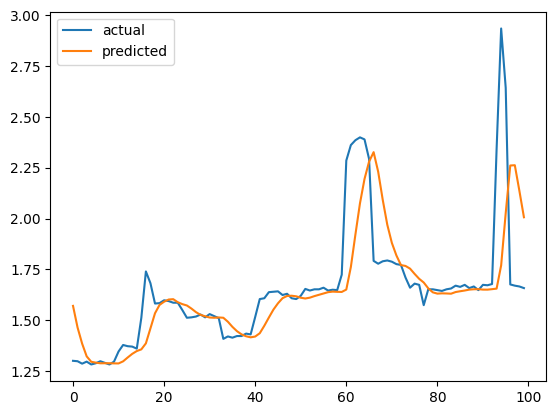

In [64]:
# Convert the output and labels to numpy arrays
test_outputs = test_outputs.detach().numpy()
y_test = y_test.numpy()

# Plot the first 100 actual and predicted values
plt.plot(y_test[200:300], label='actual')
plt.plot(test_outputs[200:300], label='predicted')
plt.legend()
plt.show()